In [5]:
!pip install opencv-python


In [6]:
!pip install numpy pandas matplotlib opencv-python scikit-learn tensorflow


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
IMG_SIZE = 224
TRAIN_DIR = "ISIC_2016_Training_Data"
LABELS_CSV = "ISIC_2016_Training_Part3_GroundTruth.csv"


In [5]:
df = pd.read_csv(LABELS_CSV)
df.columns = ["image_id", "diagnosis"]
df["label"] = df["diagnosis"].map({"benign": 0, "malignant": 1})
df["image_path"] = df["image_id"].apply(lambda x: os.path.join(TRAIN_DIR, x + ".jpg"))
df = df[["image_path", "label"]]
df.head(25)

,image_path,label
0,ISIC_2016_Training_Data\ISIC_0000001.jpg,0
1,ISIC_2016_Training_Data\ISIC_0000002.jpg,1
2,ISIC_2016_Training_Data\ISIC_0000004.jpg,1
3,ISIC_2016_Training_Data\ISIC_0000006.jpg,0
4,ISIC_2016_Training_Data\ISIC_0000007.jpg,0
5,ISIC_2016_Training_Data\ISIC_0000008.jpg,0
6,ISIC_2016_Training_Data\ISIC_0000009.jpg,0
7,ISIC_2016_Training_Data\ISIC_0000010.jpg,0
8,ISIC_2016_Training_Data\ISIC_0000011.jpg,0
9,ISIC_2016_Training_Data\ISIC_0000016.jpg,0


In [6]:
def load_images(df):
    X = []
    y = []
    for _, row in df.iterrows():
        img = load_img(row["image_path"], target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0
        X.append(img)
        y.append(row["label"])
    return np.array(X), np.array(y)

X, y = load_images(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from sklearn.utils import class_weight

# Convert labels to int (in case they are float)
y_train_int = y_train.astype(int)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.6219723183391004, 1: 2.549645390070922}


In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=17, batch_size=16)


Epoch 1/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 207ms/step - accuracy: 0.8166 - loss: 0.5025 - val_accuracy: 0.7722 - val_loss: 0.4687
Epoch 2/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7888 - loss: 0.4568 - val_accuracy: 0.8111 - val_loss: 0.4332
Epoch 3/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7704 - loss: 0.4717 - val_accuracy: 0.8167 - val_loss: 0.4288
Epoch 4/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8356 - loss: 0.3868 - val_accuracy: 0.7833 - val_loss: 0.4365
Epoch 5/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8459 - loss: 0.3474 - val_accuracy: 0.8111 - val_loss: 0.4171
Epoch 6/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8374 - loss: 0.3472 - val_accuracy: 0.7889 - val_loss: 0.4266
Epoch 7/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8453 - loss: 0.3348 - val_accuracy: 0.8222 - val_loss: 0.3989
Epoch 8/17
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8658 - loss: 0.3144 - val_accuracy: 0

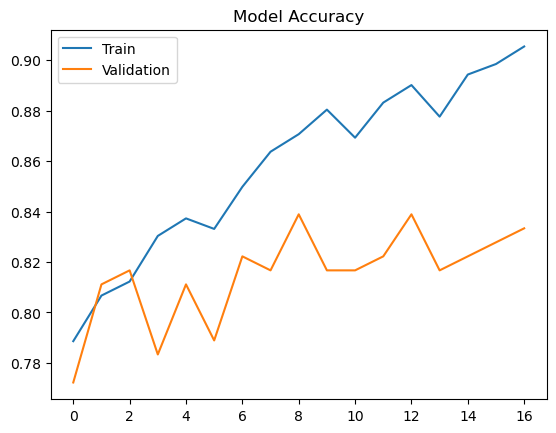

In [10]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap


In [12]:
def show_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap * alpha + np.uint8(img * 255)
    superimposed = np.clip(superimposed, 0, 255).astype("uint8")

    plt.imshow(superimposed)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()


C:\Users\dhruv\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


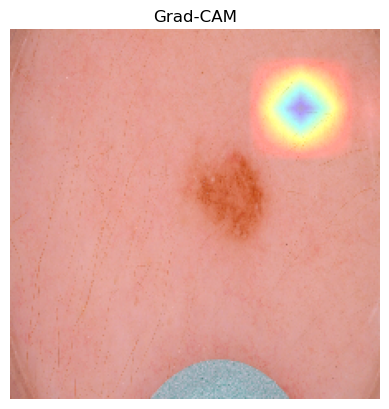

True label: 0


In [13]:
idx = 5
img = X_val[idx]
img_array = np.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
show_gradcam(img, heatmap)

print("True label:", y_val[idx])


In [14]:
TEST_DIR = "ISIC_2016_Test_Data"
TEST_LABELS_CSV = "ISIC_2016_Test_GroundTruth.csv"


In [15]:
test_df = pd.read_csv(TEST_LABELS_CSV)
test_df.columns = ["image_id", "label"]
test_df["image_path"] = test_df["image_id"].apply(lambda x: os.path.join(TEST_DIR, x + ".jpg"))
test_df["label"] = test_df["label"].astype(int)
test_df = test_df[["image_path", "label"]]
test_df.head(25)


,image_path,label
0,ISIC_2016_Test_Data\ISIC_0000012.jpg,0
1,ISIC_2016_Test_Data\ISIC_0000013.jpg,1
2,ISIC_2016_Test_Data\ISIC_0000014.jpg,0
3,ISIC_2016_Test_Data\ISIC_0000015.jpg,0
4,ISIC_2016_Test_Data\ISIC_0000020.jpg,0
5,ISIC_2016_Test_Data\ISIC_0000022.jpg,1
6,ISIC_2016_Test_Data\ISIC_0000023.jpg,0
7,ISIC_2016_Test_Data\ISIC_0000027.jpg,0
8,ISIC_2016_Test_Data\ISIC_0000036.jpg,1
9,ISIC_2016_Test_Data\ISIC_0000037.jpg,0


In [16]:
X_test, y_test = load_images(test_df)


In [17]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.8367 - loss: 0.4543
Test Accuracy: 85.45%


C:\Users\dhruv\AppData\Local\Temp\ipykernel_22644\3472416756.py:23: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\dhruv\AppData\Local\Temp\ipykernel_22644\4012867540.py:3: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


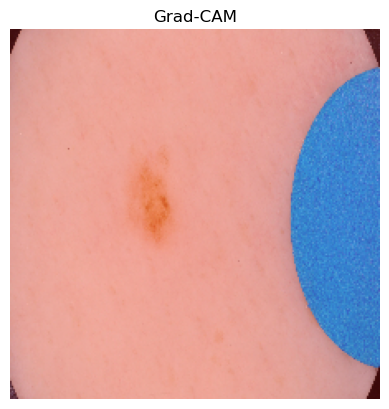

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: Benign (0.00)
Actual: Benign
--------------------------------------------------
136


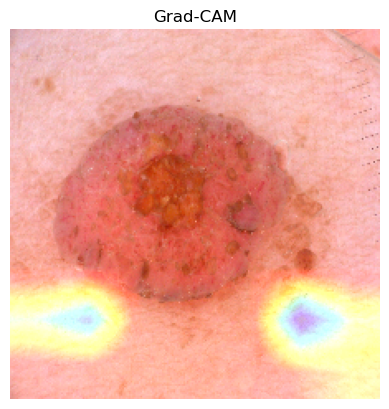

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: Benign (0.02)
Actual: Benign
--------------------------------------------------
24


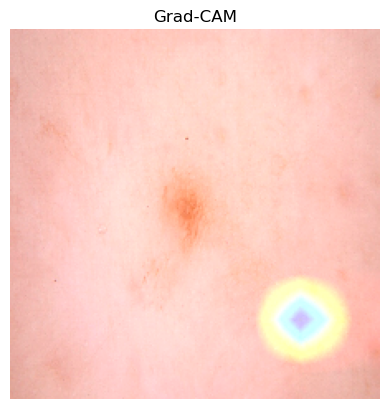

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted: Benign (0.08)
Actual: Benign
--------------------------------------------------
373


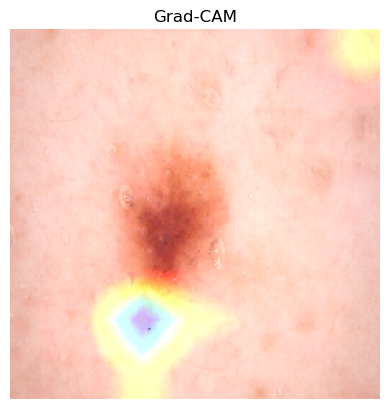

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: Benign (0.22)
Actual: Benign
--------------------------------------------------
295


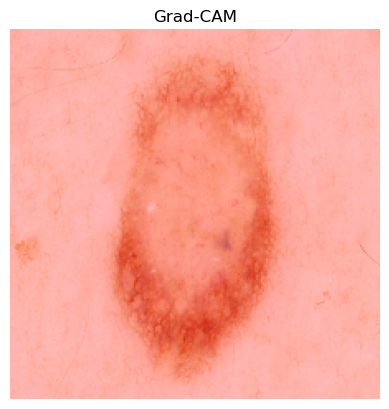

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: Benign (0.05)
Actual: Benign
--------------------------------------------------
116


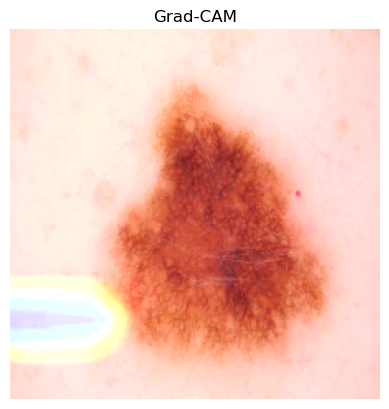

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted: Benign (0.06)
Actual: Benign
--------------------------------------------------
366


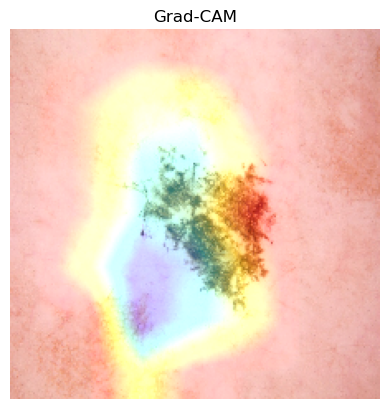

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted: Melanoma (0.61)
Actual: Benign
--------------------------------------------------
287


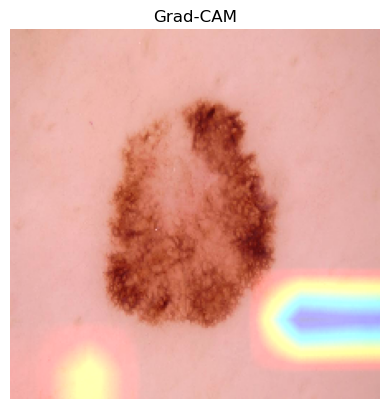

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted: Benign (0.04)
Actual: Melanoma
--------------------------------------------------
182


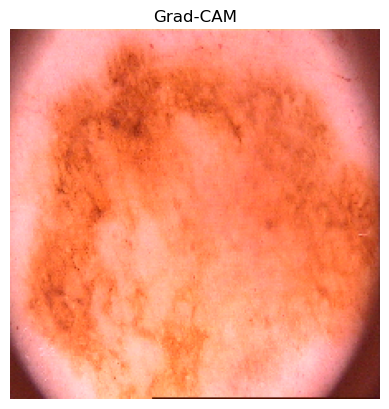

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted: Benign (0.26)
Actual: Melanoma
--------------------------------------------------
79


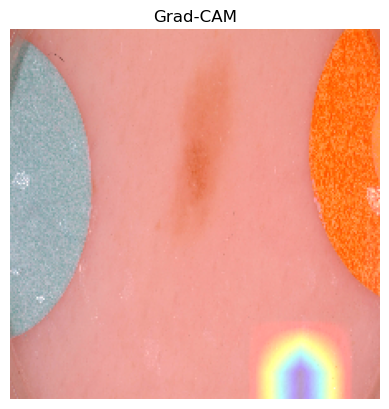

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted: Benign (0.00)
Actual: Benign
--------------------------------------------------
141


In [22]:
def gradcam_on_test(index):
    img = X_test[index]
    img_array = np.expand_dims(img, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
    show_gradcam(img, heatmap)

    pred = model.predict(img_array)[0][0]
    print(f"Predicted: {'Melanoma' if pred > 0.5 else 'Benign'} ({pred:.2f})")
    print(f"Actual: {'Melanoma' if y_test[index] == 1 else 'Benign'}")
    print("-" * 50)

# 🔁 Show Grad-CAM for 10 random test images
random_indices = random.sample(range(len(X_test)), 10)
for idx in random_indices:
    gradcam_on_test(idx)
    print(idx)


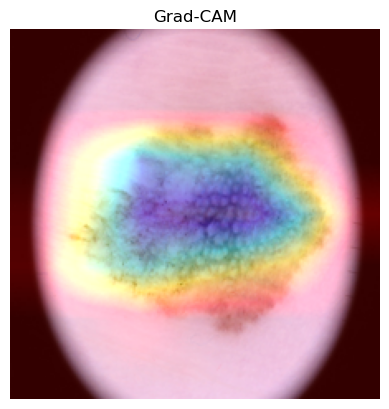

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Raw prediction: 0.5394
Prediction: Melanoma (0.54)


In [32]:
from PIL import Image

def predict_from_path(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)

    heatmap = make_gradcam_heatmap(img_array_exp, model, last_conv_layer_name="Conv_1")
    show_gradcam(img_array, heatmap)

    # pred = model.predict(img_array_exp)[0][0]
    pred = model.predict(img_array_exp)[0][0]
    print(f"Raw prediction: {pred:.4f}")

    label = "Melanoma" if pred > 0.5 else "Benign"
    print(f"Prediction: {label} ({pred:.2f})")

# Example usage 👇
predict_from_path("ISIC_2016_Test_Data/ISIC_0000287.jpg")  # Replace with your image path

In [35]:
model.save("skin_cancer_model.keras")
